In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States')
states = [s.replace('[E]', '').replace(' ', '-') for s in list(
    dfs[0]['Flag, name andpostal abbreviation[12]']['Flag, name andpostal abbreviation[12]']
)]
', '.join(states)

'Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Delaware, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New-Hampshire, New-Jersey, New-Mexico, New-York, North-Carolina, North-Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode-Island, South-Carolina, South-Dakota, Tennessee, Texas, Utah, Vermont, Virginia, Washington, West-Virginia, Wisconsin, Wyoming'

In [3]:
def load_state(state):
    print(f'loading data for state {state}')
    page = pd.read_html(f'https://www.nytimes.com/interactive/2020/11/03/us/elections/results-{state}.html')
    df = page[1]
    df = pd.DataFrame(df.iloc[:-1]) # last row is 'view results'
    df['Total votes'] = df['Total votes'].astype(int)
    df['State'] = state
    return df.sort_values('Total votes', ascending = False)

In [4]:
try:
    us_df = pd.read_pickle('./2020_election_data.pickle')
except:
    result = {}
    for s in states:
        s = s.lower()
        result[s] = load_state(s)
    
    us_df = pd.concat(result.values())
    us_df.to_pickle('./2020_election_data.pickle')
finally:
    print(f'Total: {len(us_df)}')
    display(us_df.head())

Total: 4623


,County,Margin,2016 margin,Est. votes reported,Est. votes reported.1,Total votes,Absentee,State,District,Town,Parish
4,Jefferson,Biden +13,D+7.3,>98%,NaN,324675,—,alabama,NaN,NaN,NaN
5,Madison,Trump +8,R+16.3,>98%,NaN,193955,—,alabama,NaN,NaN,NaN
0,Mobile,Trump +12,R+13.3,93%,NaN,181783,—,alabama,NaN,NaN,NaN
6,Shelby,Trump +41,R+49.4,>98%,NaN,114439,—,alabama,NaN,NaN,NaN
7,Baldwin,Trump +54,R+57.2,>98%,NaN,108945,—,alabama,NaN,NaN,NaN


In [5]:
# assuming other parties are very minimal and won't affect the votes estimation
us_df['2020_Who'] = np.where(us_df['Margin'].str.split('+', expand=True)[0].str.strip() == 'Biden','D','R')
us_df['2020_Margin'] = pd.to_numeric(us_df['Margin'].str.split('+', expand=True)[1])
us_df['2016_Who'] = us_df['2016 margin'].str.split('+', expand=True)[0].str.strip()
us_df['2016_Margin'] = pd.to_numeric(us_df['2016 margin'].str.split('+', expand=True)[1])
us_df.head()

,County,Margin,2016 margin,Est. votes reported,Est. votes reported.1,Total votes,Absentee,State,District,Town,Parish,2020_Who,2020_Margin,2016_Who,2016_Margin
4,Jefferson,Biden +13,D+7.3,>98%,NaN,324675,—,alabama,NaN,NaN,NaN,D,13.0,D,7.3
5,Madison,Trump +8,R+16.3,>98%,NaN,193955,—,alabama,NaN,NaN,NaN,R,8.0,R,16.3
0,Mobile,Trump +12,R+13.3,93%,NaN,181783,—,alabama,NaN,NaN,NaN,R,12.0,R,13.3
6,Shelby,Trump +41,R+49.4,>98%,NaN,114439,—,alabama,NaN,NaN,NaN,R,41.0,R,49.4
7,Baldwin,Trump +54,R+57.2,>98%,NaN,108945,—,alabama,NaN,NaN,NaN,R,54.0,R,57.2


In [6]:
us_df[us_df['2016_Who'].isnull()].State.unique()

array(['alaska', 'connecticut', 'maine', 'massachusetts', 'new-hampshire',
       'rhode-island', 'vermont'], dtype=object)

# Shifting to a different party

In [7]:
vote_count_threshold = 10000
has_2016_data = us_df[~us_df['2016_Who'].isnull()]
shifted = has_2016_data.loc[lambda x: x['2020_Who'] != x['2016_Who']].loc[lambda x: x['Total votes'] > vote_count_threshold]
#display(shifted)
print("% of the county shifted to a different party : " + str(len(shifted) / len(has_2016_data)))

def print_q(df):
    print('Margin Percentile: ')
    print((df['2020_Margin'] + df['2016_Margin']).quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

to_d = shifted.loc[lambda x: x['2020_Who'] == 'D']
to_r = shifted.loc[lambda x: x['2020_Who'] == 'R']

def against_df(msg, df):
    print('------')
    print(msg)
    print('------')
    print(f'len : {len(df)}')
    print_q(df)
    print(f'States: {df.State.unique()}')
    
print(f'From R to D: {len(to_d)}, From D to R: {len(to_r)}')

against_df('From R to D', to_d)
against_df('From D to R', to_r)

print('States that only move to D:')
display(set(to_d.State.unique()) - set(to_r.State.unique()))
print('States that only move to R:')
display(set(to_r.State.unique()) - set(to_d.State.unique()))

% of the county shifted to a different party : 0.020374630299046993
From R to D: 46, From D to R: 16
------
From R to D
------
len : 46
Margin Percentile: 
0.25     4.625
0.50     6.045
0.75     9.075
0.90    11.400
0.95    11.725
0.99    14.915
dtype: float64
States: ['arizona' 'california' 'colorado' 'florida' 'illinois' 'indiana' 'kansas'
 'maryland' 'michigan' 'minnesota' 'mississippi' 'new-jersey'
 'north-carolina' 'ohio' 'oregon' 'pennsylvania' 'texas' 'virginia'
 'washington' 'wisconsin' 'wyoming']
------
From D to R
------
len : 16
Margin Percentile: 
0.25     3.040
0.50     6.050
0.75     9.975
0.90    17.550
0.95    18.500
0.99    19.940
dtype: float64
States: ['georgia' 'illinois' 'mississippi' 'new-york' 'north-carolina' 'ohio'
 'south-carolina' 'texas']
States that only move to D:


{'arizona',
 'california',
 'colorado',
 'florida',
 'indiana',
 'kansas',
 'maryland',
 'michigan',
 'minnesota',
 'new-jersey',
 'oregon',
 'pennsylvania',
 'virginia',
 'washington',
 'wisconsin',
 'wyoming'}

States that only move to R:


{'georgia', 'new-york', 'south-carolina'}

# Margin correlation between 2020 and 2016

In [8]:
has_2016_data[['2020_Margin', '2016_Margin']].corr()

,2020_Margin,2016_Margin
2020_Margin,1.000000,0.969486
2016_Margin,0.969486,1.000000


In [9]:
# ignore small counties
has_2016_data.loc[lambda x: x['Total votes'] > 5000].corr()

,Total votes,2020_Margin,2016_Margin
Total votes,1.000000,-0.173456,-0.167907
2020_Margin,-0.173456,1.000000,0.965652
2016_Margin,-0.167907,0.965652,1.000000


# Benford's Law

In [10]:
# use margin to estimate the vote count, this isn't accurate as other parties 
# also has a margin of the total votes, but shouldn't be a big ammount
ben_df = pd.DataFrame(us_df[['State', 'Total votes', '2020_Who', '2020_Margin']]\
                      .loc[lambda x: ~x['2020_Margin'].isnull()])
ben_df['BidenVotes'] = np.where(
    ben_df['2020_Who'] == 'D',
    ben_df['Total votes'] * ((100 + ben_df['2020_Margin']) / 200),
    ben_df['Total votes'] * ((100 - ben_df['2020_Margin']) / 200)
).astype(int)
ben_df['TrumpVotes'] = ben_df['Total votes'] - ben_df['BidenVotes']
ben_df['BidenVotesLeadingDig'] = ben_df['BidenVotes'].astype(str).str[0]
ben_df['TrumpVotesLeadingDig'] = ben_df['TrumpVotes'].astype(str).str[0]
display(ben_df.head())

,State,Total votes,2020_Who,2020_Margin,BidenVotes,TrumpVotes,BidenVotesLeadingDig,TrumpVotesLeadingDig
4,alabama,324675,D,13.0,183441,141234,1,1
5,alabama,193955,R,8.0,89219,104736,8,1
0,alabama,181783,R,12.0,79984,101799,7,1
6,alabama,114439,R,41.0,33759,80680,3,8
7,alabama,108945,R,54.0,25057,83888,2,8


In [11]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/Benford%27s_law')
exp_ben = dfs[4]["In Benford's law"]["In Benford's law"].str.replace('%','').astype(float) / 100
exp_ben.index = exp_ben.index + 1
exp_ben

1    0.301
2    0.176
3    0.125
4    0.097
5    0.079
6    0.067
7    0.058
8    0.051
9    0.046
Name: In Benford's law, dtype: float64

In [12]:
final_ben_df = pd.DataFrame({
    'LeadingDigit' : range(1, 10),
    
    'BenExp': list(exp_ben),
    
    'Biden' :  ben_df.groupby('BidenVotesLeadingDig').BidenVotesLeadingDig.count() / len(ben_df),
    
    # YES, there exists one county in NH with total 5 votes that all going to Biden :-)
    'Trump' :  ben_df.loc[ben_df['TrumpVotesLeadingDig'] != '0']\
        .groupby('TrumpVotesLeadingDig').BidenVotesLeadingDig.count() / len(ben_df),
})
final_ben_df.index = final_ben_df['LeadingDigit']
del final_ben_df['LeadingDigit']
final_ben_df

,BenExp,Biden,Trump
LeadingDigit,,,
1,0.301,0.286996,0.286771
2,0.176,0.184081,0.169283
3,0.125,0.124664,0.123094
4,0.097,0.109641,0.105605
5,0.079,0.070179,0.087668
6,0.067,0.068161,0.067937
7,0.058,0.057848,0.056278
8,0.051,0.046188,0.057848
9,0.046,0.052242,0.045291


<AxesSubplot:xlabel='LeadingDigit'>

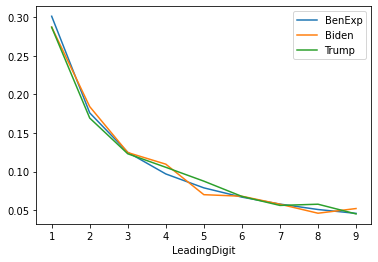

In [13]:
final_ben_df.plot()